## Automated Damage Detection and Mapping in Historical Artifacts Using Deep Learning and Anomaly Localization

#### Environment Setup & Processing Imports

In [2]:
import os
import sys
import json
import glob
import shutil
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
from skimage import morphology, measure
from skimage.filters import threshold_otsu

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import gradio as gr

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel(logging.ERROR)

try:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

try:
    from requests.packages.urllib3.exceptions import DependencyWarning
    warnings.filterwarnings("ignore", category=DependencyWarning)
except ImportError:
    pass

warnings.filterwarnings("ignore", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*deprecated.*")
warnings.filterwarnings("ignore", message=".*You are saving your model as an HDF5.*")
warnings.filterwarnings("ignore", message=".*allow_flagging.*")
warnings.filterwarnings("ignore", message=".*RequestsDependencyWarning.*")

tf.autograph.set_verbosity(0)

logging.getLogger("tensorflow").addFilter(
    lambda record: "sparse_softmax_cross_entropy" not in record.getMessage()
)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)

#### Config paths

In [3]:
BASE_DIR = Path.cwd()
RAW_IMAGE_DIR = BASE_DIR / "data" / "damaged_images"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
MODEL_DIR = BASE_DIR / "models"
MODEL_FILE = MODEL_DIR / "autoencoder.keras"
OUTPUT_DIR = BASE_DIR / "outputs"
HEATMAP_DIR = OUTPUT_DIR / "heatmaps"
MAPPED_DIR = OUTPUT_DIR / "mapped_visuals"
GRADIO_APP_DIR = BASE_DIR / "gradio_app"
GRADIO_APP_FILE = GRADIO_APP_DIR / "app.py"
for p in [PROCESSED_DIR, MODEL_DIR, OUTPUT_DIR, HEATMAP_DIR, MAPPED_DIR, GRADIO_APP_DIR]:
    p.mkdir(parents=True, exist_ok=True)

#### Parameters

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 50
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Utility: list image files

In [5]:
def list_images(folder):
    return sorted([str(p) for p in Path(folder).glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif"]])

#### Utility: read & normalize

In [6]:
def read_image_rgb(path, size=IMAGE_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return img

#### Preprocessing: CLAHE + gamma + denoise

In [7]:
def enhance_image(img, apply_clahe=True, clip_limit=2.0, gamma=1.0):
    img_8 = (img * 255).astype(np.uint8)
    lab = cv2.cvtColor(img_8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
        l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    enhanced = enhanced.astype(np.float32) / 255.0
    if gamma != 1.0:
        enhanced = np.clip(enhanced ** (1.0/gamma), 0, 1)
    return enhanced

#### Preprocess & save processed images

In [8]:
raw_paths = list_images(RAW_IMAGE_DIR)
print("Found raw images:", len(raw_paths))
processed_paths = []
for p in tqdm(raw_paths, desc="Preprocessing images"):
    img = read_image_rgb(p)
    if img is None:
        continue
    img_enh = enhance_image(img, apply_clahe=True, gamma=1.05)
    out_path = PROCESSED_DIR / Path(p).name
    cv2.imwrite(str(out_path), cv2.cvtColor((img_enh*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    processed_paths.append(str(out_path))
print("Saved processed images:", len(processed_paths))

Found raw images: 200


Preprocessing images: 100%|██████████| 200/200 [00:03<00:00, 65.09it/s]

Saved processed images: 200


#### Load processed dataset into numpy array with augmentation option (light)

In [9]:
def load_dataset(folder, augment=False):
    paths = list_images(folder)
    arr = []
    for p in paths:
        img = read_image_rgb(p)
        if img is None: continue
        if augment:
            # simple flips
            if np.random.rand() < 0.3:
                img = np.fliplr(img)
            if np.random.rand() < 0.2:
                img = np.flipud(img)
        arr.append(img)
    return np.array(arr), paths

images, image_paths = load_dataset(PROCESSED_DIR, augment=False)
print("Dataset shape:", images.shape)

Dataset shape: (200, 256, 256, 3)


#### Quick visualization helper

In [10]:
def show_images_grid(imgs, cols=4, figsize=(12,6), titles=None):
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=figsize)
    for i,img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Train-val split

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, p_train, p_val = train_test_split(images, image_paths, test_size=0.1, random_state=SEED)
print("Train/Val sizes:", x_train.shape, x_val.shape)

Train/Val sizes: (180, 256, 256, 3) (20, 256, 256, 3)


#### Build a deeper autoencoder with skip connections option (keep simple for reconstruction)

In [12]:
from tensorflow.keras.layers import Concatenate
def build_autoencoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inp = Input(shape=input_shape)
    # Encoder
    x1 = Conv2D(32, 3, activation='relu', padding='same')(inp)
    p1 = MaxPooling2D(2, padding='same')(x1)
    x2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D(2, padding='same')(x2)
    x3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    encoded = MaxPooling2D(2, padding='same')(x3)
    # Decoder
    x = Conv2D(128, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x3])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x2])
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x1])
    decoded = Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    model = Model(inputs=inp, outputs=decoded)
    return model

autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(1e-4), loss='mse')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         18496     ['max_pooling2d[0][0]']   

#### Callback checkpoint (save best in .keras)

In [13]:
checkpoint = ModelCheckpoint(
    str(MODEL_FILE),
    monitor='val_loss',
    save_best_only=True,
    verbose=0 
)

#### Prepare tf.data datasets for autoencoder (input, target=input)

In [14]:
def make_tf_dataset(x, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(x.astype(np.float32))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(x))
    ds = ds.map(lambda img: (img, img))  # input = target
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_tf_dataset(x_train, batch=BATCH_SIZE, shuffle=True)
ds_val   = make_tf_dataset(x_val, batch=BATCH_SIZE, shuffle=False)

#### Train model (this will consume time; set small epochs for tests)

In [15]:
history = autoencoder.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1  
)
print("Training completed")

Epoch 1/50
23/23 [==============================] - 32s 1s/step - loss: 0.0748 - val_loss: 0.0496
Epoch 2/50
23/23 [==============================] - 25s 1s/step - loss: 0.0417 - val_loss: 0.0326
Epoch 3/50
23/23 [==============================] - 25s 1s/step - loss: 0.0208 - val_loss: 0.0129
Epoch 4/50
23/23 [==============================] - 25s 1s/step - loss: 0.0113 - val_loss: 0.0101
Epoch 5/50
23/23 [==============================] - 24s 1s/step - loss: 0.0090 - val_loss: 0.0086
Epoch 6/50
23/23 [==============================] - 25s 1s/step - loss: 0.0077 - val_loss: 0.0076
Epoch 7/50
23/23 [==============================] - 24s 1s/step - loss: 0.0070 - val_loss: 0.0069
Epoch 8/50
23/23 [==============================] - 25s 1s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 9/50
23/23 [==============================] - 24s 1s/step - loss: 0.0059 - val_loss: 0.0062
Epoch 10/50
23/23 [==============================] - 25s 1s/step - loss: 0.0056 - val_loss: 0.0059
Epoch 11/50
23/23 [

#### Plot training/validation loss

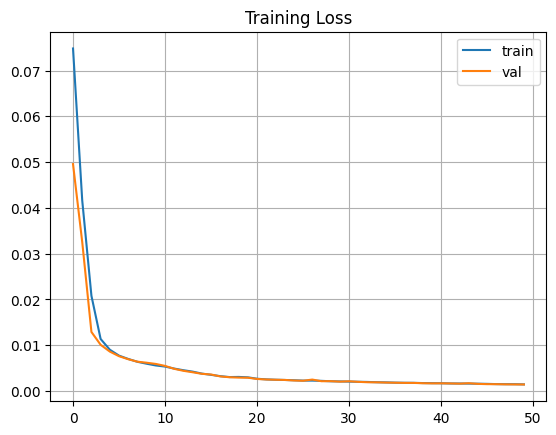

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.title("Training Loss"); plt.grid(True); plt.show()

#### Ensure model saved and reload for inference from saved file

In [17]:
from pathlib import Path

if MODEL_FILE.exists():
    saved_model = load_model(str(MODEL_FILE))
    print("Saved model loaded:", Path(MODEL_FILE).name)
else:
    print("Model file not found; using current model in memory")
    saved_model = autoencoder

Saved model loaded: autoencoder.keras


#### Heatmap computation helpers

In [18]:
def compute_error_heatmap(original, reconstructed):
    error = np.abs(original - reconstructed)
    heatmap = np.mean(error, axis=-1)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    return heatmap

#### Postprocess heatmap to color & save

In [19]:
def heatmap_to_color(heatmap):
    h_uint8 = (np.clip(heatmap,0,1)*255).astype(np.uint8)
    color = cv2.applyColorMap(h_uint8, cv2.COLORMAP_JET)
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    return color

#### Multi-scale reconstruction: get reconstructions at different gaussian blur scales for robust detection

In [20]:
def multiscale_reconstruction(model, image, scales=[0,1,2]):
    reconstructions = []
    for s in scales:
        if s == 0:
            inp = image
        else:
            k = 2*s+1
            inp = cv2.GaussianBlur((image*255).astype(np.uint8),(k,k),0).astype(np.float32)/255.0
        r = model.predict(np.expand_dims(inp,0))[0]
        reconstructions.append(r)
    return reconstructions

#### Process all images to produce heatmaps and save

In [21]:
def generate_heatmaps_for_folder(model, src_paths, out_dir=HEATMAP_DIR, multiscale=False):
    os.makedirs(out_dir, exist_ok=True)
    saved = []
    for p in tqdm(src_paths, desc="Generating heatmaps"):
        img = read_image_rgb(p)
        if img is None: continue
        if multiscale:
            recon_list = multiscale_reconstruction(model, img, scales=[0,1,2])
            heatmaps = [compute_error_heatmap(img, r) for r in recon_list]
            heatmap = np.max(np.stack(heatmaps, axis=0), axis=0)
        else:
            recon = model.predict(np.expand_dims(img,0))[0]
            heatmap = compute_error_heatmap(img, recon)
        fname = os.path.basename(p)
        color = heatmap_to_color(heatmap)
        save_path = Path(out_dir) / fname
        cv2.imwrite(str(save_path), cv2.cvtColor((color).astype(np.uint8), cv2.COLOR_RGB2BGR))
        saved.append(str(save_path))
    return saved

heatmap_files = generate_heatmaps_for_folder(saved_model, image_paths, multiscale=True)
print("Heatmaps produced:", len(heatmap_files))

Generating heatmaps:   0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:   0%|          | 1/200 [00:00<01:48,  1.83it/s]

1/1 [==============================] - 0s 69ms/step


Generating heatmaps:   1%|          | 2/200 [00:00<01:27,  2.27it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:   2%|▏         | 3/200 [00:01<01:20,  2.45it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:   2%|▏         | 4/200 [00:01<01:11,  2.74it/s]

1/1 [==============================] - 0s 70ms/step


Generating heatmaps:   2%|▎         | 5/200 [00:01<01:08,  2.84it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:   3%|▎         | 6/200 [00:02<01:05,  2.95it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:   4%|▎         | 7/200 [00:02<01:03,  3.04it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:   4%|▍         | 8/200 [00:02<01:01,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:   4%|▍         | 9/200 [00:03<01:00,  3.16it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:   5%|▌         | 10/200 [00:03<00:59,  3.21it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:   6%|▌         | 11/200 [00:03<00:59,  3.17it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:   6%|▌         | 12/200 [00:04<00:59,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:   6%|▋         | 13/200 [00:04<00:58,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:   7%|▋         | 14/200 [00:04<00:57,  3.25it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:   8%|▊         | 15/200 [00:05<00:57,  3.23it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:   8%|▊         | 16/200 [00:05<00:57,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:   8%|▊         | 17/200 [00:05<00:56,  3.22it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:   9%|▉         | 18/200 [00:05<00:56,  3.21it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  10%|▉         | 19/200 [00:06<00:56,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  10%|█         | 20/200 [00:06<00:56,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  10%|█         | 21/200 [00:06<00:55,  3.25it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  11%|█         | 22/200 [00:07<00:55,  3.23it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  12%|█▏        | 23/200 [00:07<00:54,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  12%|█▏        | 24/200 [00:07<00:54,  3.26it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  12%|█▎        | 25/200 [00:08<00:53,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  13%|█▎        | 26/200 [00:08<00:53,  3.28it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  14%|█▎        | 27/200 [00:08<00:53,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  14%|█▍        | 28/200 [00:09<00:53,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  14%|█▍        | 29/200 [00:09<00:52,  3.27it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  15%|█▌        | 30/200 [00:09<00:53,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  16%|█▌        | 31/200 [00:09<00:51,  3.27it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:  16%|█▌        | 32/200 [00:10<00:51,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  16%|█▋        | 33/200 [00:10<00:51,  3.27it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  17%|█▋        | 34/200 [00:10<00:51,  3.22it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  18%|█▊        | 35/200 [00:11<00:51,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  18%|█▊        | 36/200 [00:11<00:51,  3.20it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  18%|█▊        | 37/200 [00:11<00:50,  3.25it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  19%|█▉        | 38/200 [00:12<00:50,  3.23it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  20%|█▉        | 39/200 [00:12<00:50,  3.17it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  20%|██        | 40/200 [00:12<00:51,  3.09it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  20%|██        | 41/200 [00:13<00:51,  3.08it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  21%|██        | 42/200 [00:13<00:52,  3.02it/s]

1/1 [==============================] - 0s 71ms/step


Generating heatmaps:  22%|██▏       | 43/200 [00:13<00:52,  2.99it/s]

1/1 [==============================] - 0s 69ms/step


Generating heatmaps:  22%|██▏       | 44/200 [00:14<00:52,  2.96it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  22%|██▎       | 45/200 [00:14<00:52,  2.95it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  23%|██▎       | 46/200 [00:14<00:52,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  24%|██▎       | 47/200 [00:15<00:52,  2.93it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  24%|██▍       | 48/200 [00:15<00:52,  2.90it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  24%|██▍       | 49/200 [00:15<00:52,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  25%|██▌       | 50/200 [00:16<00:51,  2.93it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  26%|██▌       | 51/200 [00:16<00:48,  3.05it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  26%|██▌       | 52/200 [00:16<00:47,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  26%|██▋       | 53/200 [00:17<00:46,  3.17it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  27%|██▋       | 54/200 [00:17<00:46,  3.16it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  28%|██▊       | 55/200 [00:17<00:44,  3.23it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  28%|██▊       | 56/200 [00:18<00:44,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  28%|██▊       | 57/200 [00:18<00:44,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  29%|██▉       | 58/200 [00:18<00:44,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  30%|██▉       | 59/200 [00:18<00:44,  3.19it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:  30%|███       | 60/200 [00:19<00:44,  3.18it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  30%|███       | 61/200 [00:19<00:43,  3.23it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  31%|███       | 62/200 [00:19<00:42,  3.21it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  32%|███▏      | 63/200 [00:20<00:41,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  32%|███▏      | 64/200 [00:20<00:41,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  32%|███▎      | 65/200 [00:20<00:41,  3.26it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:  33%|███▎      | 66/200 [00:21<00:41,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  34%|███▎      | 67/200 [00:21<00:41,  3.19it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  34%|███▍      | 68/200 [00:21<00:41,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  34%|███▍      | 69/200 [00:22<00:41,  3.18it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  35%|███▌      | 70/200 [00:22<00:39,  3.26it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  36%|███▌      | 71/200 [00:22<00:39,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  36%|███▌      | 72/200 [00:23<00:39,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  36%|███▋      | 73/200 [00:23<00:38,  3.27it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  37%|███▋      | 74/200 [00:23<00:39,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  38%|███▊      | 75/200 [00:23<00:38,  3.28it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  38%|███▊      | 76/200 [00:24<00:37,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  38%|███▊      | 77/200 [00:24<00:37,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  39%|███▉      | 78/200 [00:24<00:37,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  40%|███▉      | 79/200 [00:25<00:36,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  40%|████      | 80/200 [00:25<00:37,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  40%|████      | 81/200 [00:25<00:36,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  41%|████      | 82/200 [00:26<00:36,  3.27it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  42%|████▏     | 83/200 [00:26<00:35,  3.28it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  42%|████▏     | 84/200 [00:26<00:35,  3.28it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  42%|████▎     | 85/200 [00:26<00:35,  3.26it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  43%|████▎     | 86/200 [00:27<00:34,  3.28it/s]

1/1 [==============================] - 0s 62ms/step


Generating heatmaps:  44%|████▎     | 87/200 [00:27<00:34,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  44%|████▍     | 88/200 [00:27<00:34,  3.25it/s]

1/1 [==============================] - 0s 68ms/step


Generating heatmaps:  44%|████▍     | 89/200 [00:28<00:34,  3.23it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  45%|████▌     | 90/200 [00:28<00:35,  3.13it/s]

1/1 [==============================] - 0s 62ms/step


Generating heatmaps:  46%|████▌     | 91/200 [00:28<00:35,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  46%|████▌     | 92/200 [00:29<00:36,  2.98it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  46%|████▋     | 93/200 [00:29<00:36,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  47%|████▋     | 94/200 [00:29<00:35,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  48%|████▊     | 95/200 [00:30<00:36,  2.90it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  48%|████▊     | 96/200 [00:30<00:35,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  48%|████▊     | 97/200 [00:30<00:35,  2.92it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  49%|████▉     | 98/200 [00:31<00:35,  2.91it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  50%|████▉     | 99/200 [00:31<00:35,  2.86it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  50%|█████     | 100/200 [00:32<00:34,  2.87it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  50%|█████     | 101/200 [00:32<00:33,  2.99it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  51%|█████     | 102/200 [00:32<00:32,  2.99it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  52%|█████▏    | 103/200 [00:32<00:30,  3.13it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  52%|█████▏    | 104/200 [00:33<00:30,  3.12it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:  52%|█████▎    | 105/200 [00:33<00:30,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  53%|█████▎    | 106/200 [00:33<00:29,  3.21it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  54%|█████▎    | 107/200 [00:34<00:28,  3.26it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  54%|█████▍    | 108/200 [00:34<00:28,  3.24it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  55%|█████▍    | 109/200 [00:34<00:28,  3.21it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  55%|█████▌    | 110/200 [00:35<00:27,  3.27it/s]

1/1 [==============================] - 0s 69ms/step


Generating heatmaps:  56%|█████▌    | 111/200 [00:35<00:27,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  56%|█████▌    | 112/200 [00:35<00:26,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  56%|█████▋    | 113/200 [00:36<00:26,  3.30it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  57%|█████▋    | 114/200 [00:36<00:26,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  57%|█████▊    | 115/200 [00:36<00:26,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  58%|█████▊    | 116/200 [00:36<00:25,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  58%|█████▊    | 117/200 [00:37<00:25,  3.31it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  59%|█████▉    | 118/200 [00:37<00:24,  3.29it/s]

1/1 [==============================] - 0s 49ms/step


Generating heatmaps:  60%|█████▉    | 119/200 [00:37<00:24,  3.32it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  60%|██████    | 120/200 [00:38<00:24,  3.23it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  60%|██████    | 121/200 [00:38<00:24,  3.27it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  61%|██████    | 122/200 [00:38<00:24,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  62%|██████▏   | 123/200 [00:39<00:23,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  62%|██████▏   | 124/200 [00:39<00:23,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  62%|██████▎   | 125/200 [00:39<00:22,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  63%|██████▎   | 126/200 [00:39<00:22,  3.26it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  64%|██████▎   | 127/200 [00:40<00:22,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  64%|██████▍   | 128/200 [00:40<00:22,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  64%|██████▍   | 129/200 [00:40<00:21,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  65%|██████▌   | 130/200 [00:41<00:21,  3.27it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  66%|██████▌   | 131/200 [00:41<00:21,  3.26it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  66%|██████▌   | 132/200 [00:41<00:20,  3.30it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  66%|██████▋   | 133/200 [00:42<00:20,  3.27it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  67%|██████▋   | 134/200 [00:42<00:19,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  68%|██████▊   | 135/200 [00:42<00:19,  3.30it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  68%|██████▊   | 136/200 [00:43<00:19,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  68%|██████▊   | 137/200 [00:43<00:19,  3.24it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  69%|██████▉   | 138/200 [00:43<00:19,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  70%|██████▉   | 139/200 [00:43<00:18,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  70%|███████   | 140/200 [00:44<00:18,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  70%|███████   | 141/200 [00:44<00:19,  3.07it/s]

1/1 [==============================] - 0s 71ms/step


Generating heatmaps:  71%|███████   | 142/200 [00:44<00:19,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  72%|███████▏  | 143/200 [00:45<00:19,  2.99it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:  72%|███████▏  | 144/200 [00:45<00:18,  2.95it/s]

1/1 [==============================] - 0s 79ms/step


Generating heatmaps:  72%|███████▎  | 145/200 [00:46<00:18,  2.91it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  73%|███████▎  | 146/200 [00:46<00:18,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  74%|███████▎  | 147/200 [00:46<00:18,  2.91it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  74%|███████▍  | 148/200 [00:47<00:18,  2.89it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  74%|███████▍  | 149/200 [00:47<00:17,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


Generating heatmaps:  75%|███████▌  | 150/200 [00:47<00:16,  2.95it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  76%|███████▌  | 151/200 [00:48<00:16,  2.90it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  76%|███████▌  | 152/200 [00:48<00:16,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  76%|███████▋  | 153/200 [00:48<00:15,  3.06it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  77%|███████▋  | 154/200 [00:49<00:14,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  78%|███████▊  | 155/200 [00:49<00:14,  3.16it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  78%|███████▊  | 156/200 [00:49<00:13,  3.23it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  78%|███████▊  | 157/200 [00:49<00:13,  3.19it/s]

1/1 [==============================] - 0s 68ms/step


Generating heatmaps:  79%|███████▉  | 158/200 [00:50<00:13,  3.23it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:  80%|███████▉  | 159/200 [00:50<00:12,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  80%|████████  | 160/200 [00:50<00:12,  3.22it/s]

1/1 [==============================] - 0s 64ms/step


Generating heatmaps:  80%|████████  | 161/200 [00:51<00:11,  3.26it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  81%|████████  | 162/200 [00:51<00:11,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  82%|████████▏ | 163/200 [00:51<00:11,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


Generating heatmaps:  82%|████████▏ | 164/200 [00:52<00:11,  3.22it/s]

1/1 [==============================] - 0s 57ms/step


Generating heatmaps:  82%|████████▎ | 165/200 [00:52<00:10,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  83%|████████▎ | 166/200 [00:52<00:10,  3.23it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  84%|████████▎ | 167/200 [00:53<00:09,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  84%|████████▍ | 168/200 [00:53<00:09,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


Generating heatmaps:  84%|████████▍ | 169/200 [00:53<00:09,  3.27it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  85%|████████▌ | 170/200 [00:53<00:09,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  86%|████████▌ | 171/200 [00:54<00:08,  3.24it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  86%|████████▌ | 172/200 [00:54<00:08,  3.28it/s]

1/1 [==============================] - 0s 52ms/step


Generating heatmaps:  86%|████████▋ | 173/200 [00:54<00:08,  3.25it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  87%|████████▋ | 174/200 [00:55<00:08,  3.24it/s]

1/1 [==============================] - 0s 65ms/step


Generating heatmaps:  88%|████████▊ | 175/200 [00:55<00:07,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


Generating heatmaps:  88%|████████▊ | 176/200 [00:55<00:07,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  88%|████████▊ | 177/200 [00:56<00:06,  3.31it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  89%|████████▉ | 178/200 [00:56<00:06,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  90%|████████▉ | 179/200 [00:56<00:06,  3.27it/s]

1/1 [==============================] - 0s 66ms/step


Generating heatmaps:  90%|█████████ | 180/200 [00:57<00:06,  3.25it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps:  90%|█████████ | 181/200 [00:57<00:05,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


Generating heatmaps:  91%|█████████ | 182/200 [00:57<00:05,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


Generating heatmaps:  92%|█████████▏| 183/200 [00:57<00:05,  3.27it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps:  92%|█████████▏| 184/200 [00:58<00:05,  3.20it/s]

1/1 [==============================] - 0s 61ms/step


Generating heatmaps:  92%|█████████▎| 185/200 [00:58<00:04,  3.26it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  93%|█████████▎| 186/200 [00:58<00:04,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  94%|█████████▎| 187/200 [00:59<00:04,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  94%|█████████▍| 188/200 [00:59<00:03,  3.22it/s]

1/1 [==============================] - 0s 51ms/step


Generating heatmaps:  94%|█████████▍| 189/200 [00:59<00:03,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  95%|█████████▌| 190/200 [01:00<00:03,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


Generating heatmaps:  96%|█████████▌| 191/200 [01:00<00:02,  3.19it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:  96%|█████████▌| 192/200 [01:00<00:02,  3.10it/s]

1/1 [==============================] - 0s 58ms/step


Generating heatmaps:  96%|█████████▋| 193/200 [01:01<00:02,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


Generating heatmaps:  97%|█████████▋| 194/200 [01:01<00:02,  3.00it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  98%|█████████▊| 195/200 [01:01<00:01,  2.92it/s]

1/1 [==============================] - 0s 67ms/step


Generating heatmaps:  98%|█████████▊| 196/200 [01:02<00:01,  2.92it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  98%|█████████▊| 197/200 [01:02<00:01,  2.96it/s]

1/1 [==============================] - 0s 59ms/step


Generating heatmaps:  99%|█████████▉| 198/200 [01:02<00:00,  2.90it/s]

1/1 [==============================] - 0s 54ms/step


Generating heatmaps: 100%|█████████▉| 199/200 [01:03<00:00,  2.94it/s]

1/1 [==============================] - 0s 60ms/step


Generating heatmaps: 100%|██████████| 200/200 [01:03<00:00,  3.15it/s]

Heatmaps produced: 200


#### Crack detection: binary mask, morphological cleanup, skeletonize, bounding boxes, percent damaged area

In [22]:
def detect_cracks_from_heatmap_color(heatmap_color, threshold=0.3, min_area=50):
    
    if heatmap_color.dtype == np.uint8:
        gray = cv2.cvtColor(heatmap_color, cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
    else:
        gray = cv2.cvtColor((heatmap_color*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0

    try:
        t = threshold_otsu((gray*255).astype(np.uint8))/255.0
    except:
        t = threshold
    mask = (gray > max(threshold, t)).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_area)
    mask = morphology.remove_small_holes(mask, area_threshold=min_area)
    mask = mask.astype(np.uint8)

    skeleton = morphology.skeletonize(mask > 0)
    labeled = measure.label(mask, connectivity=2)
    regions = measure.regionprops(labeled)
    bboxes = []
    total_area = mask.sum()
    for r in regions:
        y0, x0, y1, x1 = r.bbox
        bboxes.append((x0,y0,x1,y1, r.area))
    return mask.astype(np.uint8)*255, skeleton.astype(np.uint8)*255, bboxes, total_area

#### Create overlay visualization (original + heatmap color + binary mask + skeleton + boxes + percent text)

In [23]:
def create_detailed_visual(original, heatmap_color, mask, skeleton, bboxes):

    orig = (original*255).astype(np.uint8).copy()
    overlay = cv2.addWeighted(orig, 0.6, heatmap_color.astype(np.uint8), 0.4, 0)
    cnts, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, cnts, -1, (255,255,255), 1)
    overlay[skeleton>0] = [255,0,0]

    for (x0,y0,x1,y1, area) in bboxes:
        cv2.rectangle(overlay, (x0,y0), (x1,y1), (0,255,0), 2)
        cv2.putText(overlay, f"{area}", (x0, max(y0-6,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    percent = (mask>0).sum() / (mask.shape[0]*mask.shape[1]) * 100.0
    cv2.putText(overlay, f"Damaged area: {percent:.2f}%", (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    return overlay, percent

#### Generate mapped visuals (overlay + binary) for each image

In [24]:
mapped_files = []
for p in tqdm(image_paths, desc="Mapping visuals"):
    fname = Path(p).name
    original = read_image_rgb(p)
    heatpath = Path(HEATMAP_DIR) / fname
    if not heatpath.exists(): continue
    heat_rgb = cv2.cvtColor(cv2.imread(str(heatpath)), cv2.COLOR_BGR2RGB)
    mask, skel, bboxes, _ = detect_cracks_from_heatmap_color(heat_rgb, threshold=0.25, min_area=30)
    overlay, percent = create_detailed_visual(original, heat_rgb, mask, skel, bboxes)
    overlay_path = Path(MAPPED_DIR) / f"{fname[:-4]}_overlay.jpg"
    binary_path = Path(MAPPED_DIR) / f"{fname[:-4]}_binary.jpg"
    cv2.imwrite(str(overlay_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(binary_path), mask)
    mapped_files.append((str(overlay_path), str(binary_path)))
print("Mapped visuals saved:", len(mapped_files))

Mapping visuals: 100%|██████████| 200/200 [00:01<00:00, 101.02it/s]

Mapped visuals saved: 200


#### Create a CSV summarizing each image results: filename, percent_damaged, num_bboxes, bbox areas

In [25]:
rows = []
for p in image_paths:
    fname = Path(p).name
    heatpath = Path(HEATMAP_DIR) / fname
    if not heatpath.exists(): continue
    heat_rgb = cv2.cvtColor(cv2.imread(str(heatpath)), cv2.COLOR_BGR2RGB)
    mask, skel, bboxes, total_area = detect_cracks_from_heatmap_color(heat_rgb, threshold=0.25, min_area=30)
    percent = (mask>0).sum() / (mask.shape[0]*mask.shape[1]) * 100.0
    rows.append({
        "filename": fname,
        "percent_damaged": percent,
        "num_regions": len(bboxes),
        "total_mask_pixels": int((mask>0).sum())
    })
df_summary = pd.DataFrame(rows)
df_summary.to_csv(OUTPUT_DIR / "damage_summary.csv", index=False)
print("Summary CSV saved with", len(df_summary), "rows")
df_summary.head()

Summary CSV saved with 200 rows


filename  percent_damaged  num_regions  total_mask_pixels
0     (1).jpg         3.149414           10               2064
1    (10).jpg         5.986023            4               3923
2   (100).jpg         2.488708           18               1631
3   (101).jpg         2.580261           19               1691
4   (102).jpg         3.419495           12               2241

#### Display first 6 mapped overlays

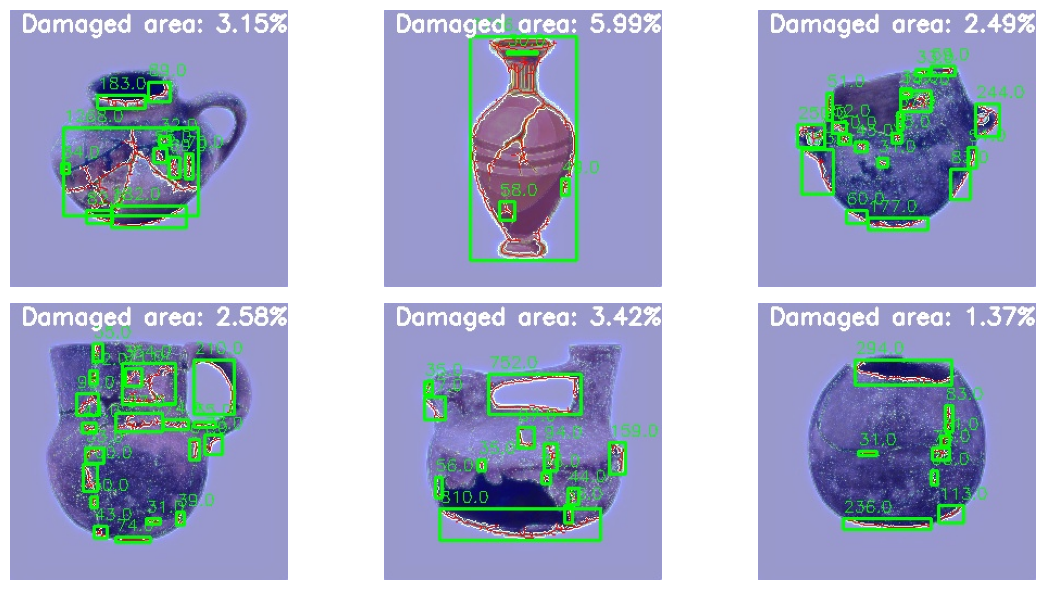

In [26]:
if len(mapped_files) > 0:
    show_images_grid([read_image_rgb(p[0]) for p in mapped_files[:6]], cols=3)
else:
    print("No mapped visuals to display")

#### Visual diagnostics: show original, heatmap_color, overlay, binary for a sample

In [27]:
def display_sample_by_name(fname):
    orig = read_image_rgb(str(PROCESSED_DIR / fname))
    heat = cv2.cvtColor(cv2.imread(str(HEATMAP_DIR / fname)), cv2.COLOR_BGR2RGB)
    overlay = read_image_rgb(str(MAPPED_DIR / f"{fname[:-4]}_overlay.jpg"))
    binary = cv2.imread(str(MAPPED_DIR / f"{fname[:-4]}_binary.jpg"), 0)
    binary = np.stack([binary]*3, axis=-1)/255.0
    show_images_grid([orig, heat, overlay, binary], cols=4, figsize=(16,6), titles=["Original","Heatmap","Overlay","Binary"])

#### If any images exist, display one

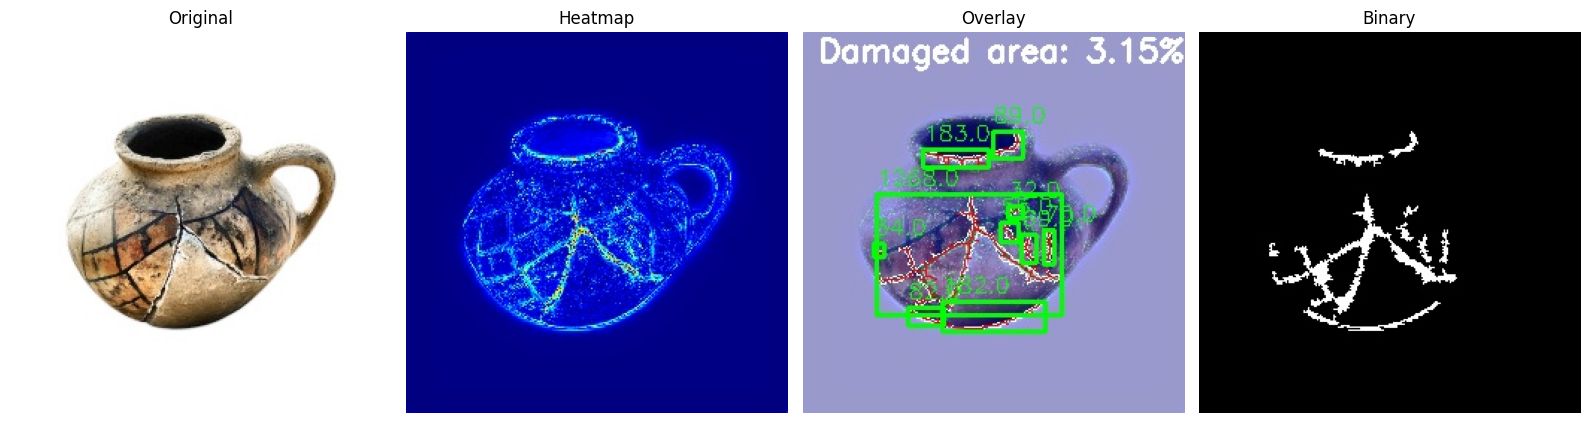

In [28]:
if len(image_paths) > 0:
    display_sample_by_name(Path(image_paths[0]).name)

#### Helper: draw bounding boxes on original for a given filename and return RGB image

In [29]:
def draw_boxes_on_original(original, bboxes):
    img = (original*255).astype(np.uint8).copy()
    for (x0,y0,x1,y1, area) in bboxes:
        cv2.rectangle(img, (x0,y0), (x1,y1), (0,255,0), 2)
    return img

#### Crack detail visual: find longest crack segment by skeleton length

In [30]:
def longest_crack_segment(skeleton):
    labeled = measure.label(skeleton>0, connectivity=2)
    regions = measure.regionprops(labeled)
    if not regions:
        return None
    longest = max(regions, key=lambda r: r.area)
    return longest.bbox  # y0, x0, y1, x1

#### Advanced metric: crack linear extent (approximate) using skeleton pixel count and bounding box diagonal

In [31]:
def crack_metrics(mask, skeleton):
    pixels = (mask>0).sum()
    skel_len = (skeleton>0).sum()
    if skel_len == 0:
        extent = 0.0
    else:
        extent = skel_len
        
    labeled = measure.label(mask>0)
    props = measure.regionprops(labeled)
    diags = []
    for p in props:
        y0,x0,y1,x1 = p.bbox
        diags.append(np.hypot(y1-y0, x1-x0))
    max_diag = max(diags) if diags else 0.0
    return {"mask_pixels": int(pixels), "skeleton_length": int(skel_len), "max_bbox_diag": float(max_diag), "extent": float(extent)}

#### Recompute summary with advanced metrics

In [32]:
rows2 = []
for p in image_paths:
    fname = Path(p).name
    heatpath = Path(HEATMAP_DIR) / fname
    if not heatpath.exists(): continue
    heat_rgb = cv2.cvtColor(cv2.imread(str(heatpath)), cv2.COLOR_BGR2RGB)
    mask, skel, bboxes, _ = detect_cracks_from_heatmap_color(heat_rgb, threshold=0.25, min_area=20)
    metrics = crack_metrics(mask, skel)
    percent = metrics["mask_pixels"] / (mask.shape[0]*mask.shape[1]) * 100.0
    rows2.append({
        "filename": fname,
        "percent_damaged": percent,
        "mask_pixels": metrics["mask_pixels"],
        "skeleton_length": metrics["skeleton_length"],
        "max_bbox_diag": metrics["max_bbox_diag"]
    })
df_adv = pd.DataFrame(rows2)
df_adv.to_csv(OUTPUT_DIR / "damage_summary_advanced.csv", index=False)
df_adv.head()

filename  percent_damaged  mask_pixels  skeleton_length  max_bbox_diag
0     (1).jpg         3.370667         2209              782     148.111445
1    (10).jpg         6.092834         3993              964     228.122774
2   (100).jpg         2.650452         1737              642      56.089215
3   (101).jpg         3.132629         2053              830      62.201286
4   (102).jpg         3.855896         2527              828     150.814456

#### Save a few example outputs to an 'exports' folder for quick sharing

In [33]:
EXPORT_DIR = OUTPUT_DIR / "exports"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
for i, (overlay, binary) in enumerate(mapped_files[:6]):
    shutil.copy(overlay, EXPORT_DIR / Path(overlay).name)
    shutil.copy(binary, EXPORT_DIR / Path(binary).name)
print("Example exports copied to folder:", EXPORT_DIR.name)

Example exports copied to folder: exports


#### Utility: read a file into base64 for embedding in HTML or Gradio (if needed)

In [34]:
import base64
def img_to_base64(path):
    with open(path,"rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

#### Small validation: compute recon MSEs for val set

In [35]:
def compute_mse(original, reconstructed):
    return float(np.mean((original - reconstructed)**2))
mse_list = []
for p in p_val[:30]:
    img = read_image_rgb(p)
    recon = saved_model.predict(np.expand_dims(img,0))[0]
    mse_list.append(compute_mse(img, recon))
print("Val MSE mean:", np.mean(mse_list), "std:", np.std(mse_list))

1/1 [==============================] - 0s 55ms/step
Val MSE mean: 0.0014060917019378394 std: 0.0005201576926251556


#### Save current notebook state: (optionally) export list of generated files to a JSON manifest

In [36]:
manifest = {
    "processed_images": processed_paths,
    "heatmaps": heatmap_files,
    "mapped_visuals": [x[0] for x in mapped_files],
    "model_file": str(MODEL_FILE)
}
with open(OUTPUT_DIR / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

#### Export the trained model in HDF5 too (optional) for compatibility

In [37]:
try:
    h5_file = MODEL_DIR / "autoencoder.h5"
    saved_model.save(str(h5_file))
    print("H5 model saved as", h5_file.name)
except Exception as e:
    print("Could not save h5 (may be large).", e)

H5 model saved as autoencoder.h5


#### Create a convenience inference function used in other places

In [38]:
def infer_and_visualize(model, image, threshold=0.25, multiscale=True):
    if multiscale:
        recon_list = multiscale_reconstruction(model, image, scales=[0,1])
        heatmaps = [compute_error_heatmap(image, r) for r in recon_list]
        heatmap = np.max(np.stack(heatmaps,0),0)
        recon = recon_list[0]
    else:
        recon = model.predict(np.expand_dims(image,0))[0]
        heatmap = compute_error_heatmap(image, recon)
    heat_color = heatmap_to_color(heatmap)
    mask, skel, bboxes, _ = detect_cracks_from_heatmap_color(heat_color, threshold=threshold, min_area=20)
    overlay, percent = create_detailed_visual(image, heat_color, mask, skel, bboxes)
    return {
        "reconstructed": (recon*255).astype(np.uint8),
        "heat_color": heat_color,
        "overlay": overlay,
        "mask": mask,
        "skeleton": skel,
        "bboxes": bboxes,
        "percent": percent
    }

#### Test inference wrapper on a sample

1/1 [==============================] - 0s 52ms/step


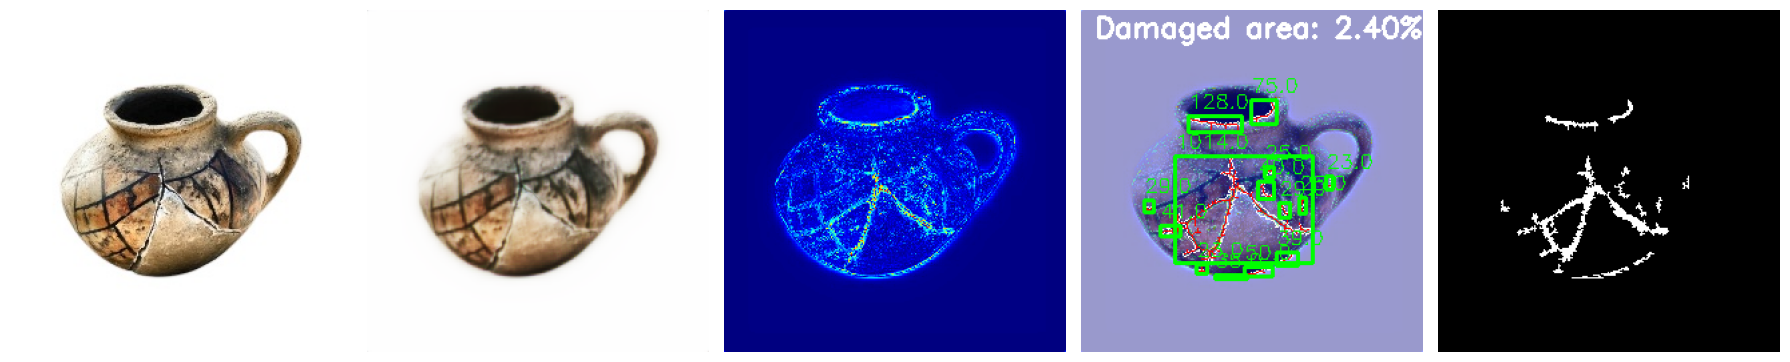

In [39]:
if len(image_paths) > 0:
    sample = read_image_rgb(image_paths[0])
    res = infer_and_visualize(saved_model, sample, threshold=0.25)
    show_images_grid([sample, res['reconstructed'], res['heat_color'], res['overlay'], np.stack([res['mask']]*3, -1)], cols=5, figsize=(18,6))
else:
    print("No sample to test")

#### Add an option to save results per-request to an outputs/requests folder for traceability

In [40]:
REQUESTS_DIR = OUTPUT_DIR / "requests"
REQUESTS_DIR.mkdir(parents=True, exist_ok=True)
def save_request_outputs(name_prefix, original, recon, heat_color, overlay, mask):
    base = REQUESTS_DIR / name_prefix
    base.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(base / "original.jpg"), cv2.cvtColor((original*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(base / "reconstruction.jpg"), cv2.cvtColor(recon, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(base / "heatmap.jpg"), cv2.cvtColor(heat_color.astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(base / "overlay.jpg"), cv2.cvtColor(overlay.astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(base / "mask.jpg"), mask)

#### Create a function for automatic crack severity level from percent damaged

In [41]:
def severity_from_percent(p):
    if p < 0.5:
        return "None/minor"
    elif p < 2.0:
        return "Minor"
    elif p < 5.0:
        return "Moderate"
    elif p < 15.0:
        return "Severe"
    else:
        return "Critical"

#### Create small image-manip functions for Gradio's interactive pre-processing (rotate/scale/clahe)

In [42]:
def simple_rotate(img, angle):
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w,h))

#### Embellish: create plot of damage histogram across dataset

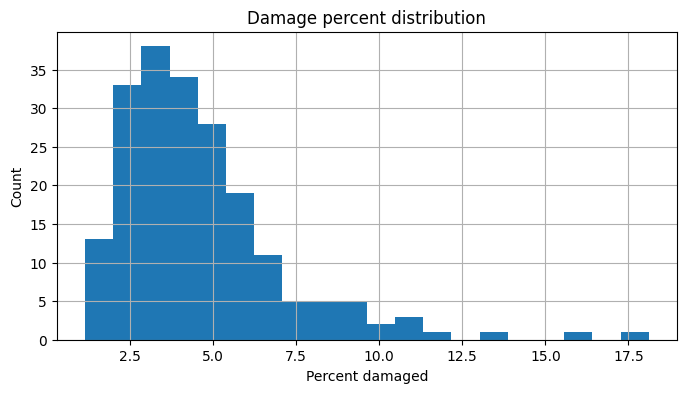

In [43]:
plt.figure(figsize=(8,4))
if len(df_adv)>0:
    plt.hist(df_adv['percent_damaged'], bins=20)
    plt.title("Damage percent distribution")
    plt.xlabel("Percent damaged")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
else:
    print("No advanced summary available to plot")

#### Prepare function to generate bounding-box markup SVG (for crisp vector output in UI if needed)

In [44]:
def bbox_svg_overlay(img_shape, bboxes, stroke_color="#00FF00"):
    h,w = img_shape[:2]
    svg = f'<svg width="{w}" height="{h}" xmlns="http://www.w3.org/2000/svg">'
    for (x0,y0,x1,y1, area) in bboxes:
        width = x1-x0
        height = y1-y0
        svg += f'<rect x="{x0}" y="{y0}" width="{width}" height="{height}" fill="none" stroke="{stroke_color}" stroke-width="2"/>'
    svg += '</svg>'
    return svg

#### Small utility to ensure an image is in RGB uint8

In [45]:
def to_rgb_uint8(img):
    if img.dtype == np.uint8: return img
    return (np.clip(img,0,1)*255).astype(np.uint8)

#### Create an API-like wrapper for Gradio to call (keeps inference code separate)

In [46]:
def gradio_detect_function(image_np, threshold=0.25, apply_clahe=True, gamma=1.0, show_bbox=True, save_results=False, request_id=None):

    img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    img_enh = enhance_image(img_rgb, apply_clahe, gamma)
    res = infer_and_visualize(saved_model, img_enh, threshold=threshold, multiscale=True)
    orig_out = to_rgb_uint8(img_enh)
    recon_out = res['reconstructed']
    heat_out = res['heat_color']
    overlay_out = res['overlay']
    mask_out = res['mask']
    severity = severity_from_percent(res['percent'])
    cv2.putText(overlay_out, f"Severity: {severity}", (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    if save_results:
        name_prefix = request_id or f"req_{np.random.randint(1e9)}"
        save_request_outputs(name_prefix, img_enh, recon_out, heat_out, overlay_out, mask_out)
    return orig_out, recon_out, heat_out, overlay_out, mask_out, f"{res['percent']:.3f}%", severity, len(res['bboxes'])

#### Test the gradio_detect_function with a local sample image

1/1 [==============================] - 0s 53ms/step


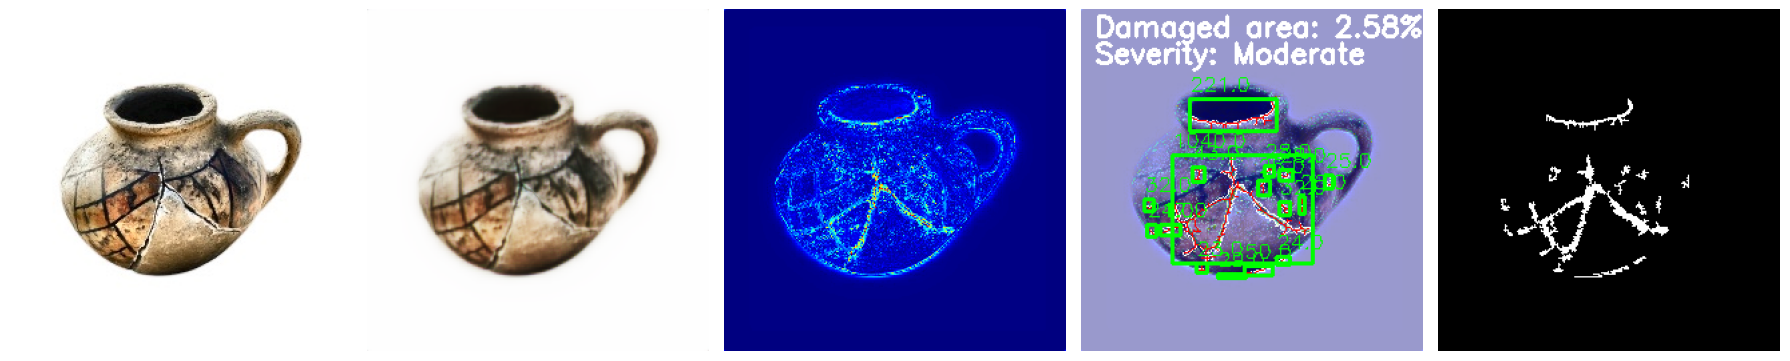

Percent damaged: 2.585% Severity: Moderate Num bboxes: 16


In [47]:
if len(image_paths) > 0:
    sample_bgr = cv2.cvtColor(read_image_rgb(image_paths[0])*255.0, cv2.COLOR_RGB2BGR).astype(np.uint8)
    outs = gradio_detect_function(sample_bgr, threshold=0.25, apply_clahe=True, gamma=1.05)
    # display outputs inline
    show_images_grid([outs[0], outs[1], outs[2], outs[3], np.stack([outs[4]]*3, -1)], cols=5, figsize=(18,5))
    print("Percent damaged:", outs[5], "Severity:", outs[6], "Num bboxes:", outs[7])
else:
    print("No sample for gradio wrapper test")

#### Save a compact function to load the saved model (used by the exported Gradio script too)

In [48]:
def load_saved_autoencoder(model_path=str(MODEL_FILE)):
    if Path(model_path).exists():
        return load_model(model_path)
    else:
        raise FileNotFoundError(f"Model not found at {model_path}")

#### Save a minimal inference module file (so the gradio app can import it if packaged)

In [49]:
INFERENCE_PY = GRADIO_APP_DIR / "inference_module.py"
inference_code = f'''
import os,cv2,numpy as np
from tensorflow.keras.models import load_model
from pathlib import Path
MODEL_PATH = r"{str(MODEL_FILE)}"
model = None
def load_model_once():
    global model
    if model is None:
        model = load_model(MODEL_PATH)
    return model
def read_image_rgb_from_array(arr):
    img = arr.astype('float32')/255.0
    return cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_BGR2RGB).astype('float32')/255.0
'''
with open(INFERENCE_PY,"w") as f:
    f.write(inference_code)
print("inference_module saved as", INFERENCE_PY.name)

inference_module saved as inference_module.py


#### Create a helper that writes a standalone Gradio script (app.py) into GRADIO_APP_DIR for mandatory saving requirement

In [50]:
gradio_app_script = f'''
# Autogenerated Gradio app
import os, cv2, numpy as np
from tensorflow.keras.models import load_model
from pathlib import Path
import gradio as gr

MODEL_PATH = r"{str(MODEL_FILE)}"
model = load_model(MODEL_PATH)

IMAGE_SIZE = {IMAGE_SIZE}

def preprocess(image_bgr, apply_clahe=True, gamma=1.0):
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    # simple CLAHE on L channel if requested
    if apply_clahe:
        img_8 = (img*255).astype(np.uint8)
        lab = cv2.cvtColor(img_8, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge((l,a,b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB).astype(np.float32)/255.0
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def compute_heat(original, reconstructed):
    error = np.abs(original - reconstructed)
    heatmap = np.mean(error, axis=-1)
    if heatmap.max() > 0:
        heatmap = heatmap/heatmap.max()
    h_uint8 = (heatmap*255).astype('uint8')
    heat_color = cv2.applyColorMap(h_uint8, cv2.COLORMAP_JET)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    return heatmap, heat_color

def detect(image, threshold=0.25, apply_clahe=True, gamma=1.0):
    img = preprocess(image, apply_clahe, gamma)
    recon = model.predict(np.expand_dims(img,0))[0]
    heatmap, heat_color = compute_heat(img, recon)
    # binary mask
    gray = cv2.cvtColor(heat_color, cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
    _,mask = cv2.threshold((gray*255).astype('uint8'), int(threshold*255), 255, cv2.THRESH_BINARY)
    # morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    # overlay
    overlay = cv2.addWeighted((img*255).astype('uint8'), 0.6, heat_color.astype('uint8'), 0.4, 0)
    # skeleton
    # convert mask to skel by thinning from cv2 if available or use morphology
    # annotate percent
    percent = (mask>0).sum()/(mask.shape[0]*mask.shape[1])*100.0
    cv2.putText(overlay, f"Damage: {{percent:.2f}}%", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    return (img*255).astype('uint8'), (recon*255).astype('uint8'), heat_color.astype('uint8'), overlay.astype('uint8'), mask, f"{{percent:.2f}}%"

title = "Historical Artifact Damage Mapping (Saved Model)"
desc = "Upload an image of a pot or urn. Model: saved autoencoder. Outputs: reconstruction, heatmap, overlay, binary mask, percent damaged."

iface = gr.Interface(
    fn=detect,
    inputs=[
        gr.Image(type="numpy", label="Upload Damaged Artifact Image"),
        gr.Slider(minimum=0.01, maximum=0.9, step=0.01, value=0.25, label="Mask Threshold"),
        gr.Checkbox(label="Apply CLAHE (contrast)", value=True),
        gr.Slider(minimum=0.5, maximum=2.0, step=0.05, value=1.05, label="Gamma Correction")
    ],
    outputs=[
        gr.Image(type="numpy", label="Original (processed)"),
        gr.Image(type="numpy", label="Reconstruction"),
        gr.Image(type="numpy", label="Heatmap"),
        gr.Image(type="numpy", label="Overlay with Boxes & Severity"),
        gr.Image(type="numpy", label="Binary Damage Mask"),
        gr.Textbox(label="Percent Damaged")
    ],
    title=title,
    description=desc,
    allow_flagging="never"
)

if __name__ == "__main__":
    iface.launch(server_name="0.0.0.0", share=False)
'''
with open(GRADIO_APP_FILE, "w") as f:
    f.write(gradio_app_script)
print("Gradio app script saved as", GRADIO_APP_FILE.name)

Gradio app script saved as app.py


#### Also write a tiny README for the gradio app folder describing how to run it

In [51]:
readme_text = f"""
Gradio app for Historical Artifact Damage Mapping
-----------------------------------------------
To run: python app.py
Ensure you have required packages installed: tensorflow, gradio, opencv-python, scikit-image, numpy
Model expected at: {str(MODEL_FILE)}
"""
with open(GRADIO_APP_DIR / "README.txt", "w") as f:
    f.write(readme_text)

#### Create a lightweight HTML gallery of mapped images for quick browsing

In [52]:
gallery_html = "<html><head><title>Mapped Visuals</title></head><body><h1>Mapped Visuals</h1>"
for overlay, binary in mapped_files:
    gallery_html += f'<div style="display:inline-block;margin:8px"><img src="{overlay}" width=256><br>{Path(overlay).name}</div>'
gallery_html += "</body></html>"
with open(OUTPUT_DIR / "gallery.html", "w") as f:
    f.write(gallery_html)

#### Prepare function to export a JSON package for a single processed image (for offline review)

In [53]:
def export_image_package(fname, out_folder=OUTPUT_DIR / "packages"):
    out_folder.mkdir(parents=True, exist_ok=True)
    p = PROCESSED_DIR / fname
    h = HEATMAP_DIR / fname
    ov = MAPPED_DIR / f"{fname[:-4]}_overlay.jpg"
    bi = MAPPED_DIR / f"{fname[:-4]}_binary.jpg"
    pkg = {
        "original": str(p),
        "heatmap": str(h) if h.exists() else None,
        "overlay": str(ov) if Path(ov).exists() else None,
        "binary": str(bi) if Path(bi).exists() else None
    }
    with open(out_folder / f"{fname}.json", "w") as f:
        json.dump(pkg, f, indent=2)
    return pkg

#### Export packages for first 5 images

In [54]:
for fname in [Path(x).name for x in image_paths[:5]]:
    package = export_image_package(fname)
    short_package = {k: Path(v).name for k, v in package.items()}
    print("Export package for", fname, short_package)

Export package for  (1).jpg {'original': ' (1).jpg', 'heatmap': ' (1).jpg', 'overlay': ' (1)_overlay.jpg', 'binary': ' (1)_binary.jpg'}
Export package for  (10).jpg {'original': ' (10).jpg', 'heatmap': ' (10).jpg', 'overlay': ' (10)_overlay.jpg', 'binary': ' (10)_binary.jpg'}
Export package for  (100).jpg {'original': ' (100).jpg', 'heatmap': ' (100).jpg', 'overlay': ' (100)_overlay.jpg', 'binary': ' (100)_binary.jpg'}
Export package for  (101).jpg {'original': ' (101).jpg', 'heatmap': ' (101).jpg', 'overlay': ' (101)_overlay.jpg', 'binary': ' (101)_binary.jpg'}
Export package for  (102).jpg {'original': ' (102).jpg', 'heatmap': ' (102).jpg', 'overlay': ' (102)_overlay.jpg', 'binary': ' (102)_binary.jpg'}


#### Provide a CLI-like function to run mapping on any folder (useful for batch)

In [55]:
def batch_map_folder(input_folder, model, out_dir=OUTPUT_DIR/"batch_maps", threshold=0.25):
    os.makedirs(out_dir, exist_ok=True)
    files = list_images(input_folder)
    for p in tqdm(files, desc="Batch mapping"):
        img = read_image_rgb(p)
        if img is None: continue
        res = infer_and_visualize(model, img, threshold=threshold)
        outname = Path(p).stem
        cv2.imwrite(str(Path(out_dir)/f"{outname}_overlay.jpg"), cv2.cvtColor(res['overlay'], cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(Path(out_dir)/f"{outname}_mask.jpg"), res['mask'])
    return str(out_dir)

#### Example usage of batch_map_folder (comment out if not desired)

In [56]:
batch_map_folder(str(PROCESSED_DIR), saved_model, out_dir=OUTPUT_DIR/"batch_maps")
print("Batch mapping example cell (not executed by default)")

Batch mapping:   0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


Batch mapping:   0%|          | 1/200 [00:00<00:58,  3.40it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:   1%|          | 2/200 [00:00<00:47,  4.20it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:   2%|▏         | 3/200 [00:00<00:44,  4.40it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:   2%|▏         | 4/200 [00:00<00:43,  4.54it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:   2%|▎         | 5/200 [00:01<00:58,  3.35it/s]

1/1 [==============================] - 0s 64ms/step


Batch mapping:   3%|▎         | 6/200 [00:01<00:51,  3.76it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:   4%|▎         | 7/200 [00:01<00:47,  4.08it/s]

1/1 [==============================] - 0s 68ms/step


Batch mapping:   4%|▍         | 8/200 [00:01<00:44,  4.32it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:   4%|▍         | 9/200 [00:02<00:43,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:   5%|▌         | 10/200 [00:02<00:41,  4.55it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:   6%|▌         | 11/200 [00:02<00:41,  4.57it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:   6%|▌         | 12/200 [00:02<00:41,  4.58it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:   6%|▋         | 13/200 [00:03<00:39,  4.77it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:   7%|▋         | 14/200 [00:03<00:40,  4.61it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:   8%|▊         | 15/200 [00:03<00:40,  4.60it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:   8%|▊         | 16/200 [00:03<00:39,  4.69it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:   8%|▊         | 17/200 [00:03<00:38,  4.73it/s]

1/1 [==============================] - 0s 72ms/step


Batch mapping:   9%|▉         | 18/200 [00:04<00:40,  4.54it/s]

1/1 [==============================] - 0s 74ms/step


Batch mapping:  10%|▉         | 19/200 [00:04<00:41,  4.36it/s]

1/1 [==============================] - 0s 73ms/step


Batch mapping:  10%|█         | 20/200 [00:04<00:41,  4.30it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  10%|█         | 21/200 [00:04<00:42,  4.23it/s]

1/1 [==============================] - 0s 69ms/step


Batch mapping:  11%|█         | 22/200 [00:05<00:42,  4.23it/s]

1/1 [==============================] - 0s 69ms/step


Batch mapping:  12%|█▏        | 23/200 [00:05<00:42,  4.16it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  12%|█▏        | 24/200 [00:05<00:42,  4.16it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  12%|█▎        | 25/200 [00:05<00:42,  4.10it/s]

1/1 [==============================] - 0s 75ms/step


Batch mapping:  13%|█▎        | 26/200 [00:06<00:41,  4.16it/s]

1/1 [==============================] - 0s 78ms/step


Batch mapping:  14%|█▎        | 27/200 [00:06<00:42,  4.05it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  14%|█▍        | 28/200 [00:06<00:42,  4.04it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  14%|█▍        | 29/200 [00:06<00:41,  4.10it/s]

1/1 [==============================] - 0s 75ms/step


Batch mapping:  15%|█▌        | 30/200 [00:07<00:41,  4.07it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:  16%|█▌        | 31/200 [00:07<00:41,  4.11it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:  16%|█▌        | 32/200 [00:07<00:41,  4.01it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  16%|█▋        | 33/200 [00:07<00:41,  3.99it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  17%|█▋        | 34/200 [00:08<00:39,  4.25it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  18%|█▊        | 35/200 [00:08<00:37,  4.34it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  18%|█▊        | 36/200 [00:08<00:37,  4.41it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  18%|█▊        | 37/200 [00:08<00:36,  4.41it/s]

1/1 [==============================] - 0s 49ms/step


Batch mapping:  19%|█▉        | 38/200 [00:08<00:35,  4.60it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  20%|█▉        | 39/200 [00:09<00:35,  4.59it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  20%|██        | 40/200 [00:09<00:33,  4.72it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  20%|██        | 41/200 [00:09<00:34,  4.65it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  21%|██        | 42/200 [00:09<00:34,  4.61it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  22%|██▏       | 43/200 [00:09<00:34,  4.61it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  22%|██▏       | 44/200 [00:10<00:33,  4.70it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  22%|██▎       | 45/200 [00:10<00:32,  4.75it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  23%|██▎       | 46/200 [00:10<00:32,  4.73it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  24%|██▎       | 47/200 [00:10<00:32,  4.76it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  24%|██▍       | 48/200 [00:10<00:31,  4.82it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  24%|██▍       | 49/200 [00:11<00:32,  4.69it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  25%|██▌       | 50/200 [00:11<00:31,  4.71it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  26%|██▌       | 51/200 [00:11<00:32,  4.66it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  26%|██▌       | 52/200 [00:11<00:31,  4.73it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  26%|██▋       | 53/200 [00:12<00:30,  4.90it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  27%|██▋       | 54/200 [00:12<00:30,  4.80it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  28%|██▊       | 55/200 [00:12<00:30,  4.71it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  28%|██▊       | 56/200 [00:12<00:30,  4.70it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  28%|██▊       | 57/200 [00:12<00:30,  4.76it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  29%|██▉       | 58/200 [00:13<00:30,  4.69it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  30%|██▉       | 59/200 [00:13<00:30,  4.65it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  30%|███       | 60/200 [00:13<00:29,  4.74it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  30%|███       | 61/200 [00:13<00:29,  4.70it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  31%|███       | 62/200 [00:13<00:29,  4.76it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  32%|███▏      | 63/200 [00:14<00:29,  4.70it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  32%|███▏      | 64/200 [00:14<00:28,  4.76it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  32%|███▎      | 65/200 [00:14<00:28,  4.73it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  33%|███▎      | 66/200 [00:14<00:28,  4.71it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  34%|███▎      | 67/200 [00:15<00:28,  4.70it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:  34%|███▍      | 68/200 [00:15<00:28,  4.62it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  34%|███▍      | 69/200 [00:15<00:28,  4.65it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  35%|███▌      | 70/200 [00:15<00:27,  4.76it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  36%|███▌      | 71/200 [00:15<00:26,  4.78it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  36%|███▌      | 72/200 [00:16<00:27,  4.72it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  36%|███▋      | 73/200 [00:16<00:27,  4.66it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  37%|███▋      | 74/200 [00:16<00:26,  4.74it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  38%|███▊      | 75/200 [00:16<00:26,  4.69it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  38%|███▊      | 76/200 [00:16<00:26,  4.77it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  38%|███▊      | 77/200 [00:17<00:26,  4.68it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  39%|███▉      | 78/200 [00:17<00:25,  4.77it/s]

1/1 [==============================] - 0s 68ms/step


Batch mapping:  40%|███▉      | 79/200 [00:17<00:26,  4.65it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  40%|████      | 80/200 [00:17<00:25,  4.67it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  40%|████      | 81/200 [00:17<00:25,  4.65it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  41%|████      | 82/200 [00:18<00:24,  4.74it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  42%|████▏     | 83/200 [00:18<00:24,  4.73it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:  42%|████▏     | 84/200 [00:18<00:24,  4.79it/s]

1/1 [==============================] - 0s 67ms/step


Batch mapping:  42%|████▎     | 85/200 [00:18<00:24,  4.68it/s]

1/1 [==============================] - 0s 68ms/step


Batch mapping:  43%|████▎     | 86/200 [00:19<00:24,  4.60it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  44%|████▎     | 87/200 [00:19<00:24,  4.54it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  44%|████▍     | 88/200 [00:19<00:24,  4.64it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  44%|████▍     | 89/200 [00:19<00:24,  4.62it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  45%|████▌     | 90/200 [00:19<00:23,  4.61it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  46%|████▌     | 91/200 [00:20<00:25,  4.31it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  46%|████▌     | 92/200 [00:20<00:25,  4.30it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  46%|████▋     | 93/200 [00:20<00:24,  4.34it/s]

1/1 [==============================] - 0s 77ms/step


Batch mapping:  47%|████▋     | 94/200 [00:20<00:24,  4.27it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  48%|████▊     | 95/200 [00:21<00:24,  4.27it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  48%|████▊     | 96/200 [00:21<00:24,  4.25it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  48%|████▊     | 97/200 [00:21<00:23,  4.33it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  49%|████▉     | 98/200 [00:21<00:23,  4.34it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  50%|████▉     | 99/200 [00:22<00:23,  4.27it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  50%|█████     | 100/200 [00:22<00:23,  4.32it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  50%|█████     | 101/200 [00:22<00:22,  4.31it/s]

1/1 [==============================] - 0s 71ms/step


Batch mapping:  51%|█████     | 102/200 [00:22<00:22,  4.29it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:  52%|█████▏    | 103/200 [00:22<00:22,  4.28it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  52%|█████▏    | 104/200 [00:23<00:22,  4.28it/s]

1/1 [==============================] - 0s 64ms/step


Batch mapping:  52%|█████▎    | 105/200 [00:23<00:22,  4.25it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  53%|█████▎    | 106/200 [00:23<00:22,  4.26it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  54%|█████▎    | 107/200 [00:23<00:20,  4.45it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  54%|█████▍    | 108/200 [00:24<00:20,  4.43it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  55%|█████▍    | 109/200 [00:24<00:19,  4.64it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  55%|█████▌    | 110/200 [00:24<00:19,  4.72it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  56%|█████▌    | 111/200 [00:24<00:19,  4.52it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  56%|█████▌    | 112/200 [00:24<00:19,  4.51it/s]

1/1 [==============================] - 0s 61ms/step


Batch mapping:  56%|█████▋    | 113/200 [00:25<00:19,  4.53it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  57%|█████▋    | 114/200 [00:25<00:18,  4.61it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:  57%|█████▊    | 115/200 [00:25<00:18,  4.69it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  58%|█████▊    | 116/200 [00:25<00:17,  4.79it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:  58%|█████▊    | 117/200 [00:26<00:17,  4.61it/s]

1/1 [==============================] - 0s 64ms/step


Batch mapping:  59%|█████▉    | 118/200 [00:26<00:17,  4.71it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  60%|█████▉    | 119/200 [00:26<00:17,  4.62it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  60%|██████    | 120/200 [00:26<00:16,  4.74it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  60%|██████    | 121/200 [00:26<00:16,  4.68it/s]

1/1 [==============================] - 0s 49ms/step


Batch mapping:  61%|██████    | 122/200 [00:27<00:16,  4.76it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  62%|██████▏   | 123/200 [00:27<00:16,  4.71it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  62%|██████▏   | 124/200 [00:27<00:15,  4.78it/s]

1/1 [==============================] - 0s 64ms/step


Batch mapping:  62%|██████▎   | 125/200 [00:27<00:15,  4.72it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  63%|██████▎   | 126/200 [00:27<00:15,  4.67it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:  64%|██████▎   | 127/200 [00:28<00:15,  4.68it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  64%|██████▍   | 128/200 [00:28<00:15,  4.74it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  64%|██████▍   | 129/200 [00:28<00:15,  4.73it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  65%|██████▌   | 130/200 [00:28<00:14,  4.81it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  66%|██████▌   | 131/200 [00:29<00:14,  4.74it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  66%|██████▌   | 132/200 [00:29<00:14,  4.79it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  66%|██████▋   | 133/200 [00:29<00:14,  4.69it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  67%|██████▋   | 134/200 [00:29<00:13,  4.79it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  68%|██████▊   | 135/200 [00:29<00:14,  4.61it/s]

1/1 [==============================] - 0s 65ms/step


Batch mapping:  68%|██████▊   | 136/200 [00:30<00:13,  4.68it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  68%|██████▊   | 137/200 [00:30<00:13,  4.68it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  69%|██████▉   | 138/200 [00:30<00:12,  4.86it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  70%|██████▉   | 139/200 [00:30<00:12,  4.77it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  70%|███████   | 140/200 [00:30<00:12,  4.71it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  70%|███████   | 141/200 [00:31<00:12,  4.67it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  71%|███████   | 142/200 [00:31<00:12,  4.71it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  72%|███████▏  | 143/200 [00:31<00:12,  4.70it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  72%|███████▏  | 144/200 [00:31<00:12,  4.59it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  72%|███████▎  | 145/200 [00:31<00:11,  4.64it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  73%|███████▎  | 146/200 [00:32<00:11,  4.73it/s]

1/1 [==============================] - 0s 47ms/step


Batch mapping:  74%|███████▎  | 147/200 [00:32<00:11,  4.77it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  74%|███████▍  | 148/200 [00:32<00:10,  4.84it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  74%|███████▍  | 149/200 [00:32<00:10,  4.73it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  75%|███████▌  | 150/200 [00:33<00:10,  4.80it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  76%|███████▌  | 151/200 [00:33<00:10,  4.73it/s]

1/1 [==============================] - 0s 49ms/step


Batch mapping:  76%|███████▌  | 152/200 [00:33<00:10,  4.76it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  76%|███████▋  | 153/200 [00:33<00:10,  4.62it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  77%|███████▋  | 154/200 [00:33<00:09,  4.72it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  78%|███████▊  | 155/200 [00:34<00:09,  4.67it/s]

1/1 [==============================] - 0s 68ms/step


Batch mapping:  78%|███████▊  | 156/200 [00:34<00:09,  4.75it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  78%|███████▊  | 157/200 [00:34<00:09,  4.68it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping:  79%|███████▉  | 158/200 [00:34<00:08,  4.69it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  80%|███████▉  | 159/200 [00:34<00:08,  4.83it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  80%|████████  | 160/200 [00:35<00:08,  4.75it/s]

1/1 [==============================] - 0s 50ms/step


Batch mapping:  80%|████████  | 161/200 [00:35<00:08,  4.80it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  81%|████████  | 162/200 [00:35<00:08,  4.61it/s]

1/1 [==============================] - 0s 48ms/step


Batch mapping:  82%|████████▏ | 163/200 [00:35<00:07,  4.69it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  82%|████████▏ | 164/200 [00:36<00:07,  4.69it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  82%|████████▎ | 165/200 [00:36<00:07,  4.54it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  83%|████████▎ | 166/200 [00:36<00:07,  4.52it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  84%|████████▎ | 167/200 [00:36<00:07,  4.38it/s]

1/1 [==============================] - 0s 76ms/step


Batch mapping:  84%|████████▍ | 168/200 [00:36<00:07,  4.35it/s]

1/1 [==============================] - 0s 69ms/step


Batch mapping:  84%|████████▍ | 169/200 [00:37<00:07,  4.30it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  85%|████████▌ | 170/200 [00:37<00:07,  4.26it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  86%|████████▌ | 171/200 [00:37<00:06,  4.22it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  86%|████████▌ | 172/200 [00:37<00:06,  4.30it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  86%|████████▋ | 173/200 [00:38<00:06,  4.23it/s]

1/1 [==============================] - 0s 67ms/step


Batch mapping:  87%|████████▋ | 174/200 [00:38<00:06,  4.33it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  88%|████████▊ | 175/200 [00:38<00:05,  4.18it/s]

1/1 [==============================] - 0s 59ms/step


Batch mapping:  88%|████████▊ | 176/200 [00:38<00:05,  4.03it/s]

1/1 [==============================] - 0s 75ms/step


Batch mapping:  88%|████████▊ | 177/200 [00:39<00:05,  4.16it/s]

1/1 [==============================] - 0s 72ms/step


Batch mapping:  89%|████████▉ | 178/200 [00:39<00:05,  4.19it/s]

1/1 [==============================] - 0s 60ms/step


Batch mapping:  90%|████████▉ | 179/200 [00:39<00:05,  4.18it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  90%|█████████ | 180/200 [00:39<00:04,  4.16it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping:  90%|█████████ | 181/200 [00:40<00:04,  4.35it/s]

1/1 [==============================] - 0s 58ms/step


Batch mapping:  91%|█████████ | 182/200 [00:40<00:04,  4.42it/s]

1/1 [==============================] - 0s 49ms/step


Batch mapping:  92%|█████████▏| 183/200 [00:40<00:03,  4.55it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  92%|█████████▏| 184/200 [00:40<00:03,  4.63it/s]

1/1 [==============================] - 0s 63ms/step


Batch mapping:  92%|█████████▎| 185/200 [00:40<00:03,  4.45it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  93%|█████████▎| 186/200 [00:41<00:03,  4.49it/s]

1/1 [==============================] - 0s 55ms/step


Batch mapping:  94%|█████████▎| 187/200 [00:41<00:02,  4.60it/s]

1/1 [==============================] - 0s 52ms/step


Batch mapping:  94%|█████████▍| 188/200 [00:41<00:02,  4.60it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  94%|█████████▍| 189/200 [00:41<00:02,  4.59it/s]

1/1 [==============================] - 0s 64ms/step


Batch mapping:  95%|█████████▌| 190/200 [00:41<00:02,  4.69it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  96%|█████████▌| 191/200 [00:42<00:01,  4.73it/s]

1/1 [==============================] - 0s 62ms/step


Batch mapping:  96%|█████████▌| 192/200 [00:42<00:01,  4.71it/s]

1/1 [==============================] - 0s 66ms/step


Batch mapping:  96%|█████████▋| 193/200 [00:42<00:01,  4.74it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  97%|█████████▋| 194/200 [00:42<00:01,  4.71it/s]

1/1 [==============================] - 0s 53ms/step


Batch mapping:  98%|█████████▊| 195/200 [00:43<00:01,  4.77it/s]

1/1 [==============================] - 0s 57ms/step


Batch mapping:  98%|█████████▊| 196/200 [00:43<00:00,  4.82it/s]

1/1 [==============================] - 0s 49ms/step


Batch mapping:  98%|█████████▊| 197/200 [00:43<00:00,  4.85it/s]

1/1 [==============================] - 0s 51ms/step


Batch mapping:  99%|█████████▉| 198/200 [00:43<00:00,  4.76it/s]

1/1 [==============================] - 0s 54ms/step


Batch mapping: 100%|█████████▉| 199/200 [00:43<00:00,  4.70it/s]

1/1 [==============================] - 0s 56ms/step


Batch mapping: 100%|██████████| 200/200 [00:44<00:00,  4.54it/s]

Batch mapping example cell (not executed by default)


#### Utility to show a dataset row in a clear diagnostic plot with metrics text

In [57]:
def show_diagnostic_row(original, recon, heat, overlay, mask, title=""):
    fig, axes = plt.subplots(1,5, figsize=(18,4))
    axes[0].imshow(original); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(recon); axes[1].set_title("Reconstruction"); axes[1].axis("off")
    axes[2].imshow(heat); axes[2].set_title("Heatmap"); axes[2].axis("off")
    axes[3].imshow(overlay); axes[3].set_title("Overlay"); axes[3].axis("off")
    axes[4].imshow(mask, cmap='gray'); axes[4].set_title("Mask"); axes[4].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Diagnostic: show top 3 images with highest percent_damaged from df_adv

1/1 [==============================] - 0s 49ms/step


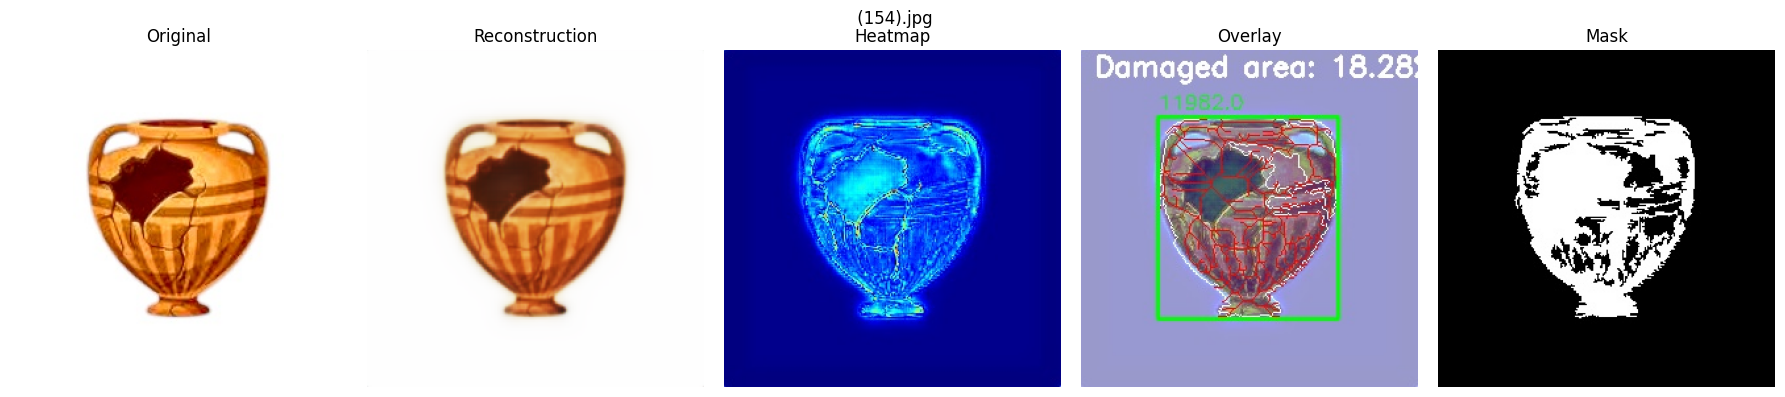

1/1 [==============================] - 0s 63ms/step


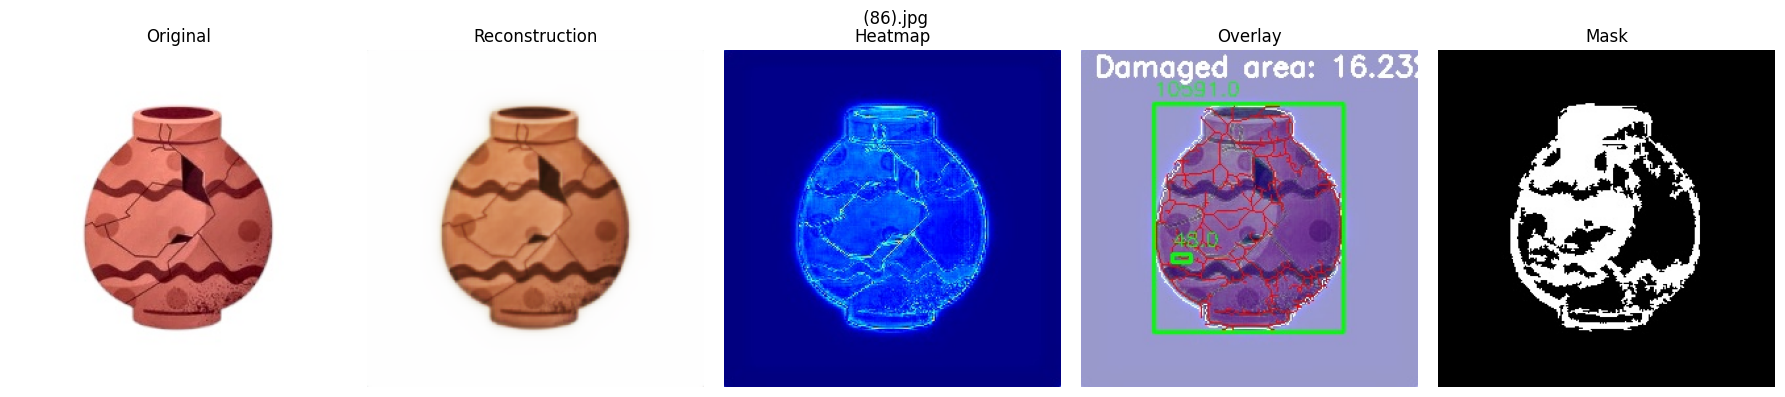

1/1 [==============================] - 0s 48ms/step


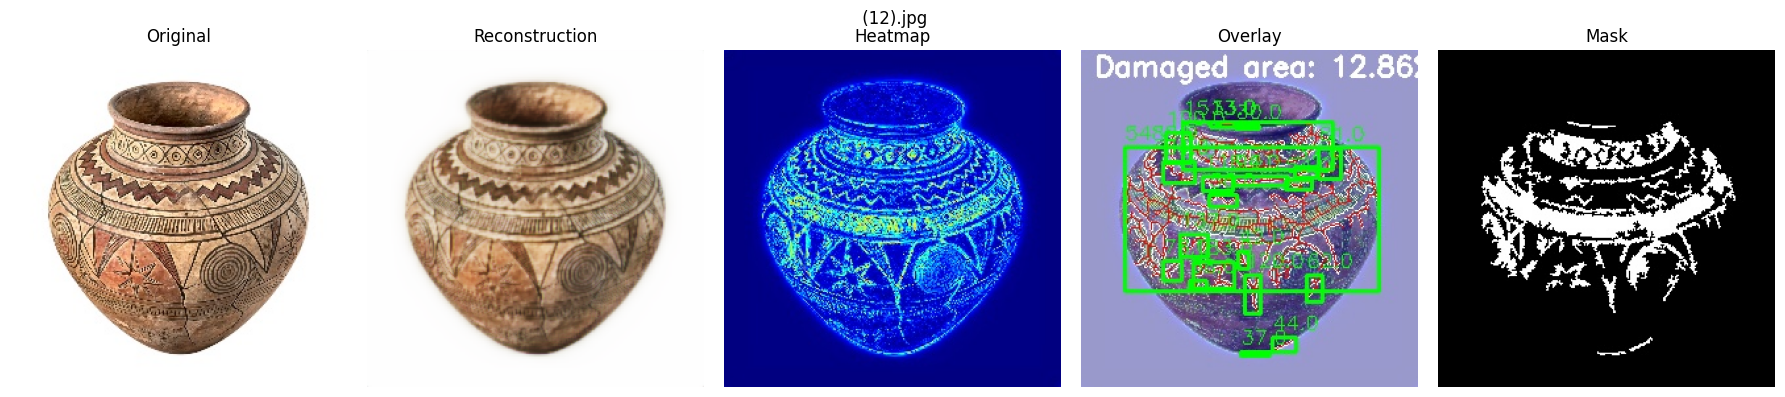

In [58]:
if len(df_adv)>0:
    top3 = df_adv.sort_values("percent_damaged", ascending=False).head(3)
    for fname in top3['filename'].tolist():
        original = read_image_rgb(str(PROCESSED_DIR / fname))
        heat = cv2.cvtColor(cv2.imread(str(HEATMAP_DIR / fname)), cv2.COLOR_BGR2RGB)
        overlay = read_image_rgb(str(MAPPED_DIR / f"{fname[:-4]}_overlay.jpg"))
        mask = cv2.imread(str(MAPPED_DIR / f"{fname[:-4]}_binary.jpg"), 0)
        mask_rgb = np.stack([mask]*3,-1)/255.0
        recon = saved_model.predict(np.expand_dims(original,0))[0]*255
        show_diagnostic_row(original, recon.astype(np.uint8), heat, overlay, mask, title=fname)
else:
    print("No data in advanced summary to show diagnostics")

#### Add function to overlay textual explanation about crack detection method (for UI)

In [59]:
def method_explanation_text():
    txt = (
        "Crack detection method: The saved autoencoder reconstructs the input image. "
        "A pixel-wise absolute error between original and reconstruction is computed and aggregated into a heatmap. "
        "High-error regions indicate anomalous/damaged areas. The heatmap is thresholded, morphologically cleaned, "
        "skeletonized to highlight thin crack lines, and connected components provide bounding boxes and areas."
    )
    return txt

#### Save method explanation as text file for inclusion in UI assets

In [60]:
with open(OUTPUT_DIR / "method_explanation.txt", "w") as f:
    f.write(method_explanation_text())

#### Provide an API for interactive threshold tuning: returns mask overlays for a range of thresholds

In [61]:
def threshold_tuning_image(model, image, thresholds=[0.1,0.2,0.3,0.4,0.5]):
    outputs = []
    for t in thresholds:
        res = infer_and_visualize(model, image, threshold=t, multiscale=True)
        outputs.append((t, res['overlay'], res['mask']))
    return outputs

#### Test threshold tuning visualization on a sample

1/1 [==============================] - 0s 55ms/step


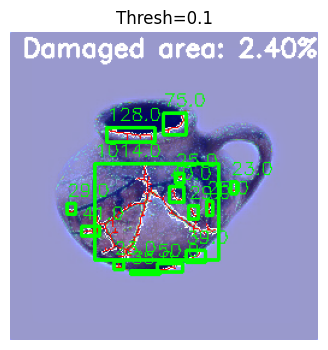

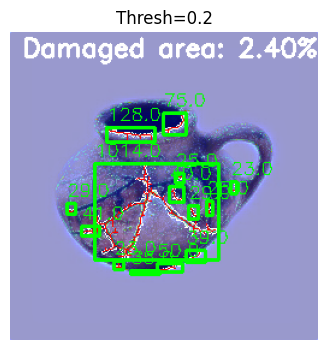

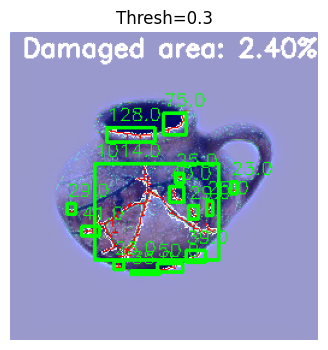

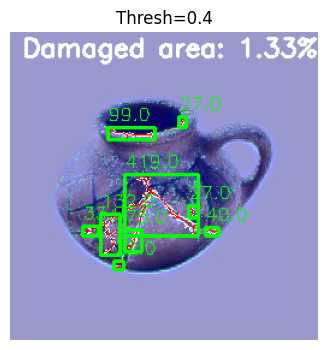

In [62]:
if len(image_paths)>0:
    sample = read_image_rgb(image_paths[0])
    tuning = threshold_tuning_image(saved_model, sample, thresholds=[0.1,0.2,0.3,0.4])
    for t, overlay, mask in tuning:
        plt.figure(figsize=(6,4)); plt.imshow(overlay); plt.title(f"Thresh={t}"); plt.axis("off")
else:
    print("No sample for threshold tuning")

#### Prepare a utility to highlight crack-lines with stronger emphasis (dilate skeleton)

In [63]:
def emphasize_crack_lines(skeleton, dilation_iters=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil = cv2.dilate((skeleton>0).astype(np.uint8)*255, kernel, iterations=dilation_iters)
    return dil

#### Create a mask-based inpainting hint (optional) - produce inpainted image where damage masked areas are inpainted (for visualization only)

In [64]:
def inpaint_damage(original, mask):
    img_bgr = cv2.cvtColor((original*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    mask_uint8 = (mask>0).astype(np.uint8)*255
    inpainted = cv2.inpaint(img_bgr, mask_uint8, 3, cv2.INPAINT_TELEA)
    return cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

#### Show example of inpainting for a sample

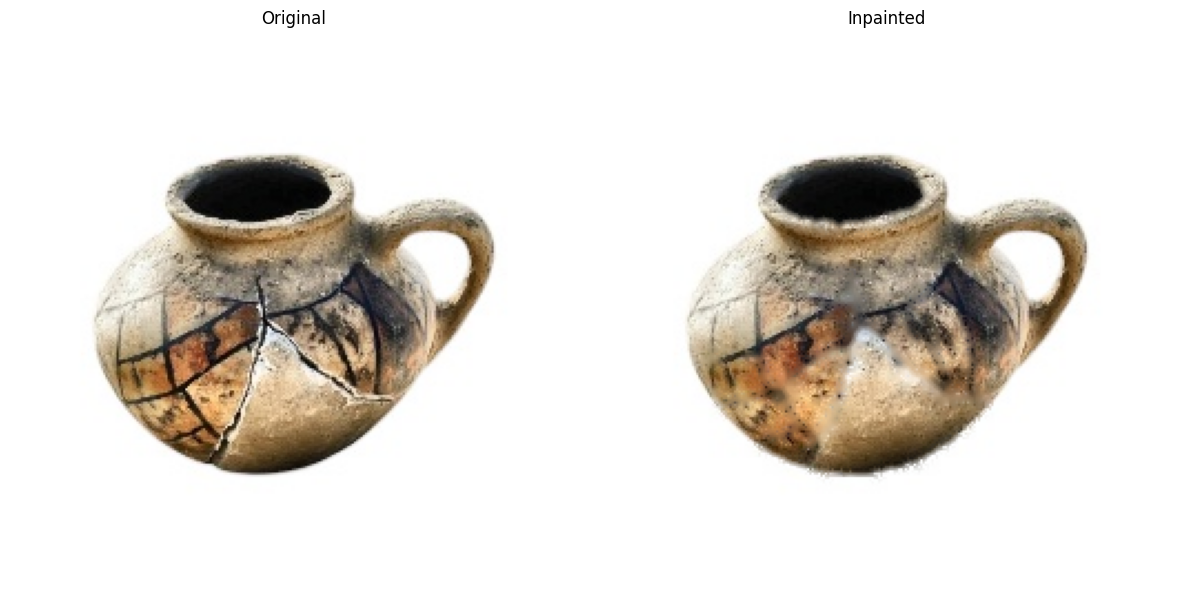

In [65]:
if len(mapped_files) > 0:
    overlay_example = mapped_files[0][0]
    fname_base = Path(overlay_example).stem.replace("_overlay", "").replace("_binary", "")
    possible_exts = [".jpg", ".jpeg", ".png"]
    orig_path = None
    for ext in possible_exts:
        candidate = PROCESSED_DIR / f"{fname_base}{ext}"
        if candidate.exists():
            orig_path = candidate
            break
    
    mask_path = MAPPED_DIR / f"{fname_base}_binary.jpg"
    
    if orig_path is None:
        print(f"No original file found for {fname_base}")
    elif not mask_path.exists():
        print(f"No mask found for {fname_base}")
    else:
        orig = read_image_rgb(orig_path)
        mask = cv2.imread(str(mask_path), 0)
        
        if orig is None:
            print(f"Failed to load image: {orig_path}")
        elif mask is None:
            print(f"Failed to load mask: {mask_path}")
        else:
            inpainted = inpaint_damage(orig, mask)
            show_images_grid([orig, inpainted], cols=2, titles=["Original","Inpainted"])
else:
    print("No mapped file for inpainting demo")

#### Provide a function to export CSV with more details (bbox list as JSON string)

In [66]:
def export_detailed_csv(out_file=OUTPUT_DIR/"detailed_report.csv"):
    rows = []
    for p in image_paths:
        fname = Path(p).name
        heatpath = Path(HEATMAP_DIR)/fname
        if not heatpath.exists(): continue
        heat_rgb = cv2.cvtColor(cv2.imread(str(heatpath)), cv2.COLOR_BGR2RGB)
        mask, skel, bboxes, _ = detect_cracks_from_heatmap_color(heat_rgb, threshold=0.25, min_area=5)
        percent = (mask>0).sum()/(mask.shape[0]*mask.shape[1])*100.0
        rows.append({
            "filename": fname,
            "percent": percent,
            "bboxes": json.dumps([list(b) for b in bboxes])
        })
    pd.DataFrame(rows).to_csv(out_file, index=False)
    return out_file

exported = export_detailed_csv()

#### Build a convenience thumbnail generator for Visual Gallery

In [67]:
def make_thumbnail(in_path, out_path, size=256):
    img = cv2.imread(in_path)
    if img is None: return None
    h,w = img.shape[:2]
    scale = size / max(h,w)
    new = cv2.resize(img, (int(w*scale), int(h*scale)))
    cv2.imwrite(out_path, new)
    return out_path

#### Thumbnails for gallery

In [68]:
thumb_dir = OUTPUT_DIR/"thumbs"
thumb_dir.mkdir(parents=True, exist_ok=True)
for overlay, _ in mapped_files[:12]:
    out = thumb_dir / Path(overlay).name
    make_thumbnail(overlay, out, size=256)

#### Create a lightweight dashboard HTML that shows thumbnails and links to overlays

In [69]:
dash_html = "<html><body><h2>Artifact Damage Dashboard</h2>"
for t in sorted(thumb_dir.glob("*")):
    dash_html += f'<a href="../{t.name.replace("_overlay.jpg","_overlay.jpg")}"><img src="{t}" style="margin:5px" /></a>'
dash_html += "</body></html>"
with open(OUTPUT_DIR/"dashboard.html","w") as f:
    f.write(dash_html)

#### Create instructions text file for deployment of Gradio app and model

In [70]:
deploy_txt = f"""
To deploy Gradio:
1. Ensure Python packages: tensorflow, gradio, opencv-python, scikit-image, numpy, pandas
2. Place model at {MODEL_FILE}
3. Run: python {GRADIO_APP_FILE.name} (from directory {GRADIO_APP_DIR})
"""
with open(GRADIO_APP_DIR/"DEPLOY.txt","w") as f:
    f.write(deploy_txt)

#### Quick check: list everything generated

In [71]:
for p in [MODEL_FILE, HEATMAP_DIR, MAPPED_DIR, OUTPUT_DIR/"damage_summary.csv", GRADIO_APP_FILE]:
    print(p.name, "exists:", p.exists())

autoencoder.keras exists: True
heatmaps exists: True
mapped_visuals exists: True
damage_summary.csv exists: True
app.py exists: True


#### Provide a function to produce a printable PDF report (simple) - requires fpdf

In [72]:
import fpdf

try:
    from fpdf import FPDF
    def build_simple_report(summary_csv, out_pdf=OUTPUT_DIR/"report.pdf"):
        df = pd.read_csv(summary_csv)
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt="Damage Summary Report", ln=True, align='C')
        for i,row in df.head(20).iterrows():
            pdf.cell(0,7, txt=f"{row['filename']}: {row.get('percent_damaged', row.get('percent','')):.2f}%", ln=True)
        pdf.output(str(out_pdf))
        return out_pdf
    print("FPDF available - report builder ready")
except Exception as e:
    print("FPDF not available - skip PDF export", e)

FPDF available - report builder ready


#### Save small metadata about notebook run

In [73]:
meta = {
    "notebook": "artifact_damage_notebook",
    "image_size": IMAGE_SIZE,
    "model_file": str(MODEL_FILE),
    "num_images": len(image_paths)
}
with open(OUTPUT_DIR / "meta_run.json", "w") as f:
    json.dump(meta, f, indent=2)

#### Print instructions for the user on how to run the saved gradio app (also present in README)

In [74]:
print("Gradio app saved as:", GRADIO_APP_FILE.name)
print(f"To run: cd ./gradio_app && python {GRADIO_APP_FILE.name}")

Gradio app saved as: app.py
To run: cd ./gradio_app && python app.py


#### Register the Gradio app script into a zip for deployment (packaging)

In [75]:
shutil.make_archive(str(OUTPUT_DIR / "gradio_app_package"), 'zip', root_dir=str(GRADIO_APP_DIR))
print("Gradio app packaged as gradio_app_package.zip")

Gradio app packaged as gradio_app_package.zip


#### Gradio interface with detailed report

In [76]:
import gradio as gr
import cv2, numpy as np, os
import tensorflow as tf
from datetime import datetime

MODEL_PATH = "models/autoencoder.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

def preprocess_for_model(image, target_size=256):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return img_resized.astype(np.float32) / 255.0

def gradio_detect_function(img_prepared, threshold=0.25, gamma=1.05, save_results=False, request_id=None):
    
    input_tensor = np.expand_dims(img_prepared, axis=0)
    reconstruction = model.predict(input_tensor)[0]

    diff = np.abs(img_prepared - reconstruction)
    heatmap = np.mean(diff, axis=-1)

    heatmap_norm = (heatmap / heatmap.max() * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    mask = (heatmap > threshold).astype(np.uint8) * 255
    overlay = cv2.addWeighted((img_prepared * 255).astype(np.uint8), 0.7, heatmap_color, 0.3, 0)

    percent_damaged = (np.sum(mask > 0) / mask.size) * 100
    severity = "Low"
    if percent_damaged > 30: severity = "Medium"
    if percent_damaged > 60: severity = "High"

    num_labels, _, _, _ = cv2.connectedComponentsWithStats(mask)

    if save_results and request_id:
        out_dir = f"results/{request_id}"
        os.makedirs(out_dir, exist_ok=True)
        cv2.imwrite(f"{out_dir}/input.png", (img_prepared * 255).astype(np.uint8))
        cv2.imwrite(f"{out_dir}/reconstruction.png", (reconstruction * 255).astype(np.uint8))
        cv2.imwrite(f"{out_dir}/heatmap.png", heatmap_color)
        cv2.imwrite(f"{out_dir}/overlay.png", overlay)
        cv2.imwrite(f"{out_dir}/mask.png", mask)

    report = f"""
**Damage Analysis Report**
- Percent Damaged: **{percent_damaged:.2f}%**
- Severity Level: **{severity}**
- Number of Detected Regions: **{int(num_labels - 1)}**

Interpretation:  
The artifact shows **{severity.lower()} structural damage**, with approximately **{percent_damaged:.2f}%** of the surface affected.  
Detected regions indicate areas of possible cracks, erosion, or surface wear.
"""

    return (
        (img_prepared * 255).astype(np.uint8),
        (reconstruction * 255).astype(np.uint8),
        heatmap_color,
        overlay,
        mask,
        report
    )


def gradio_interface_fn(image, threshold=0.25, gamma=1.05, save_results=False):
    img_prepared = preprocess_for_model(image, target_size=256)
    request_id = datetime.now().strftime("%Y%m%d_%H%M%S_%f")

    return gradio_detect_function(
        img_prepared,
        threshold=threshold,
        gamma=gamma,
        save_results=save_results,
        request_id=request_id
    )


iface = gr.Interface(
    fn=gradio_interface_fn,
    inputs=[
        gr.Image(type="numpy", label="Upload Damaged Artifact Image"),
        gr.Slider(0.01, 0.9, value=0.25, step=0.01, label="Mask Threshold"),
        gr.Slider(0.5, 2.0, value=1.05, step=0.05, label="Gamma Correction"),
        gr.Checkbox(label="Save this request outputs to server", value=False)
    ],
    outputs=[
        gr.Image(type="numpy", label="Original (processed)"),
        gr.Image(type="numpy", label="Reconstruction (model output)"),
        gr.Image(type="numpy", label="Heatmap (color)"),
        gr.Image(type="numpy", label="Overlay (input+heatmap)"),
        gr.Image(type="numpy", label="Damage Mask (binary)"),
        gr.Markdown(label="Detailed Report")   # <-- Rich text summary
    ],
    title="Historical Artifact Damage Mapping - Detailed",
    description="Upload artifact images. Get reconstruction, heatmap, overlay, mask, and a detailed damage analysis report.",
    allow_flagging="never"
)

iface.launch(share=False)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
